In [0]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing

import warnings
warnings.filterwarnings('ignore')

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
if not os.path.exists('./Online20Retail.xlsx'):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2020-05-22 05:08:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  22.62M  11.7MB/s    in 1.9s    

2020-05-22 05:08:11 (11.7 MB/s) - ‘Online Retail.xlsx’ saved [23715344/23715344]



In [3]:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if 'Online' in filename:
            print(os.path.join(dirname, filename))

./Online Retail.xlsx


In [4]:
df = pd.read_excel('./Online Retail.xlsx', sheet_name=0)
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
175304,551950,21506,"FANCY FONT BIRTHDAY CARD,",12,2011-05-05 11:38:00,0.42,14911.0,EIRE
102321,545013,22402,MAGNETS PACK OF 4 VINTAGE COLLAGE,12,2011-02-25 13:09:00,1.25,13093.0,United Kingdom
105866,545294,22027,TEA PARTY BIRTHDAY CARD,12,2011-03-01 12:07:00,0.42,17965.0,United Kingdom
242818,558371,23298,SPOTTY BUNTING,24,2011-06-28 15:44:00,10.79,NaN,United Kingdom
466711,576329,22379,RECYCLING BAG RETROSPOT,3,2011-11-14 15:22:00,4.13,NaN,United Kingdom
159599,550348,20981,12 PENCILS TALL TUBE WOODLAND,24,2011-04-18 09:38:00,0.85,16947.0,United Kingdom
309031,564061,23135,SMALL ZINC HEART WALL ORGANISER,2,2011-08-22 14:38:00,5.75,14505.0,United Kingdom
329325,565841,37327,ASSTD MULTICOLOUR CIRCLES MUG,6,2011-09-07 12:04:00,0.97,NaN,United Kingdom
521056,580311,22224,WHITE LOVEBIRD LANTERN,6,2011-12-02 14:48:00,2.95,18245.0,United Kingdom
182119,552520,21524,DOORMAT SPOTTY HOME SWEET HOME,1,2011-05-09 16:34:00,15.79,NaN,United Kingdom


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# remove missing values

df.dropna(inplace=True, axis=0)
df.isnull().sum()
df.shape

(406829, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [0]:
df.StockCode = df.StockCode.astype('str')

In [9]:
# number of unique customers
df.CustomerID.nunique()

4372

In [10]:
df.CustomerID.value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
12943.0       1
13135.0       1
18068.0       1
17347.0       1
16093.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [0]:
# uniqe customers
customers = df.CustomerID.keys().tolist()

In [0]:
# split the dataset based on the customers
# 90% - 10%

import random
customers_train  = random.sample(customers, int(0.9*len(customers)))

# create the train and test dataset
train_df = df[df['CustomerID'].isin(customers_train)]
valid_df = df[~df['CustomerID'].isin(customers_train)]

In [13]:
print('Shape of the train set ', train_df.shape)
print('Shape of the validation set', valid_df.shape)

Shape of the train set  (226488, 8)
Shape of the validation set (180341, 8)


In [16]:
%%time

# create a list of purchases maded by the customers

purchases_train = []
purchases_valid = []

# populate the list with the product codes

for i in tqdm(train_df['CustomerID']):
    temp = train_df.loc[train_df['CustomerID'] == i, 'StockCode'].tolist()
    purchases_train.append(temp)
    
for i in tqdm(valid_df['CustomerID']):
    temp = valid_df.loc[valid_df['CustomerID'] == i, 'StockCode'].tolist()
    purchases_valid.append(temp)

100%|██████████| 180341/180341 [01:49<00:00, 1643.65it/s]

CPU times: user 4min 17s, sys: 1.46 s, total: 4min 19s
Wall time: 4min 18s


In [25]:
cores = multiprocessing.cpu_count() # number of cores available
cores

2

In [0]:
from gensim.models import Word2Vec

# to use skip gram architecture, set sg =1
model = Word2Vec(window=5, sg =1, negative= 10,
                alpha= 0.03,
                min_alpha = 0.0007, 
                workers = 8,
                seed = 1234)

In [31]:
%%time
model.build_vocab(purchases_train, progress_per= 100000)

INFO - 05:30:19: collecting all words and their counts
INFO - 05:30:19: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 05:30:26: PROGRESS: at sentence #100000, processed 59252164 words, keeping 3538 word types
INFO - 05:30:35: PROGRESS: at sentence #200000, processed 136392645 words, keeping 3572 word types
INFO - 05:30:37: collected 3572 word types from a corpus of 161637462 raw words and 226488 sentences
INFO - 05:30:37: Loading a fresh vocabulary
INFO - 05:30:37: effective_min_count=5 retains 3572 unique words (100% of original 3572, drops 0)
INFO - 05:30:37: effective_min_count=5 leaves 161637462 word corpus (100% of original 161637462, drops 0)
INFO - 05:30:37: deleting the raw counts dictionary of 3572 items
INFO - 05:30:37: sample=0.001 downsamples 8 most-common words
INFO - 05:30:37: downsampling leaves estimated 160959002 word corpus (99.6% of prior 161637462)
INFO - 05:30:37: estimated required memory for 3572 words and 100 dimensions: 4643600 bytes


CPU times: user 18.6 s, sys: 13 ms, total: 18.7 s
Wall time: 18.7 s


In [32]:
%%time
# train
# model.corpus_count is the number of training examples
model.train(purchases_train, 
            total_examples= model.corpus_count,
            epochs= 2,
            report_delay=60.0, # report every 60 seconds
            )

INFO - 05:30:49: training model with 8 workers on 3572 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=10 window=5
INFO - 05:30:51: EPOCH 1 - PROGRESS: at 0.15% examples, 83758 words/s, in_qsize 16, out_qsize 0
INFO - 05:31:51: EPOCH 1 - PROGRESS: at 6.40% examples, 147527 words/s, in_qsize 15, out_qsize 0
INFO - 05:32:51: EPOCH 1 - PROGRESS: at 13.62% examples, 148095 words/s, in_qsize 15, out_qsize 0
INFO - 05:33:51: EPOCH 1 - PROGRESS: at 20.79% examples, 148287 words/s, in_qsize 15, out_qsize 0
INFO - 05:34:51: EPOCH 1 - PROGRESS: at 27.46% examples, 148562 words/s, in_qsize 15, out_qsize 1
INFO - 05:35:51: EPOCH 1 - PROGRESS: at 34.09% examples, 148805 words/s, in_qsize 15, out_qsize 0
INFO - 05:36:51: EPOCH 1 - PROGRESS: at 40.71% examples, 148870 words/s, in_qsize 15, out_qsize 0
INFO - 05:37:51: EPOCH 1 - PROGRESS: at 47.26% examples, 148614 words/s, in_qsize 15, out_qsize 1
INFO - 05:38:51: EPOCH 1 - PROGRESS: at 53.29% examples, 148694 words/s, in_qsize 15,

CPU times: user 1h 11min 34s, sys: 6.26 s, total: 1h 11min 41s
Wall time: 36min 24s


(321916901, 323274924)

In [33]:
# As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:
model.init_sims(replace=True)

INFO - 06:08:32: precomputing L2-norms of word weight vectors


In [34]:
print(model)

Word2Vec(vocab=3572, size=100, alpha=0.03)


In [37]:
# extract all vectors
X = model[model.wv.vocab]
X.shape

(3572, 100)

In [0]:
import pickle
pickle.dump(X, open('X_vector.pkl', 'wb'))

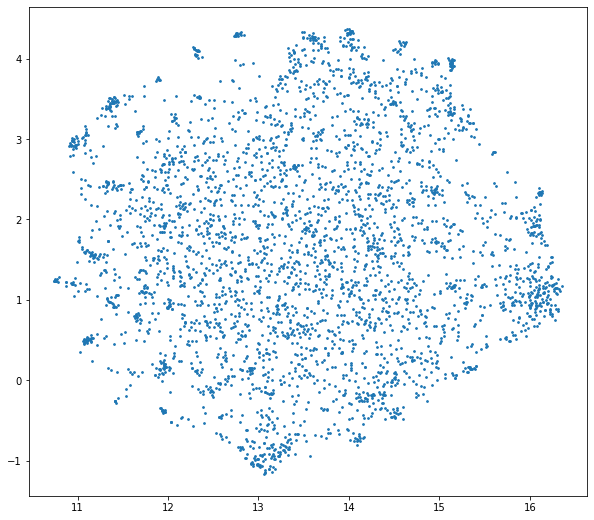

In [44]:
# Visualize word2vec embeddings

import umap
cluster_embeddings = umap.UMAP(n_neighbors= 30, n_components = 2, min_dist= 0.0, random_state= 42).fit_transform(X)

plt.figure(figsize= (10, 9))
plt.scatter(cluster_embeddings[:,0], cluster_embeddings[:, 1], s=3)

Now that we have created word2vec embeddings for every product, which is based on the product code or StockCode, we can identify similar products based on their embeddings

In [47]:
products = train_df[['StockCode', 'Description']]

products.drop_duplicates(subset='StockCode', inplace=True, keep= 'last')
products

,StockCode,Description
902,21895,POTTING SHED SOW 'N' GROW SET
1985,20957,PORCELAIN HANGING BELL SMALL
2457,21488,RED WHITE SCARF HOT WATER BOTTLE
3103,35271S,GOLD PRINT PAPER BAG
5024,16161M,WRAP PINK FLOCK
...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS
541905,22899,CHILDREN'S APRON DOLLY GIRL
541906,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE


In [82]:
# creating a product-id and product-description dictionary

product_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

# check a sample
keys = random.sample(list(product_dict), 10)
list(zip(keys, [product_dict[k] for k in keys]))

[('23318', ['BOX OF 6 MINI VINTAGE CRACKERS']),
 ('21128', ['GOLD FISHING GNOME']),
 ('21793', ['CLASSIC FRENCH STYLE BASKET BROWN']),
 ('22910', ['PAPER CHAIN KIT VINTAGE CHRISTMAS']),
 ('21392', ['RED POLKADOT PUDDING BOWL']),
 ('22858', ['EASTER TIN KEEPSAKE']),
 ('20695', ['FLORAL BLUE MONSTER']),
 ('21877', ['HOME SWEET HOME MUG']),
 ('22920', ['HERB MARKER BASIL']),
 ('21192', ['WHITE BELL HONEYCOMB PAPER '])]

In [97]:
# Given a product embedding, find products with similar embeddings
temp1 = model.most_similar('21785', topn=5)
temp1

[('85179A', 0.6353557109832764),
 ('21786', 0.6351869702339172),
 ('20980', 0.5926169157028198),
 ('84827', 0.5493873357772827),
 ('21544', 0.5321046113967896)]

In [95]:
for j in temp1:
    print(product_dict[j[0]][0], j[1])

GREEN BITTY LIGHT CHAIN 0.6353557109832764
POLKADOT RAIN HAT  0.6351869702339172
36 PENCILS TUBE POSY 0.5926169157028198
ASS DES PHONE SPONGE CRAFT STICKER 0.5493873357772827
SKULLS  WATER TRANSFER TATTOOS  0.5321046113967896


In [0]:
 #find 6 most similar products

def similar_products(v, n =6):

    # extract most similar products for the input vector
    ms = model.most_similar(v, topn = n+1)

    # extract name and similarity scores for similar products
    new_ms= []
    for j in ms:
        pair = (product_dict[j[0]][0], j[1])
        new_ms.append(pair)

    return new_ms

In [108]:
# testing
stock_code_test = '90019A'
print('Product description of the code: {} is {}'.format(stock_code_test, product_dict[stock_code_test]))
print('\nFind similar products for the product code:{}'.format(stock_code_test))
similar_products(stock_code_test)

Product description of the code: 90019A is ['SILVER M.O.P ORBIT BRACELET']

Find similar products for the product code:90019A


[('BAROQUE BUTTERFLY EARRINGS BLACK', 0.7397165298461914),
 ('CLEAR ACRYLIC FACETED BANGLE', 0.7394231557846069),
 ('ANTIQUE OLIVE GREEN FLOWER EARRINGS', 0.684190034866333),
 ('WHITE  ROSEBUD PEARL BRACELET', 0.6607744693756104),
 ('AMBER GLASS TASSLE BAG CHARM', 0.6382941603660583),
 ('SILVER BRACELET W PASTEL FLOWER', 0.6322119235992432),
 ('CRACKED GLAZE EARRINGS RED', 0.6224693059921265)]